Analysis of FairSD vs Fair flat10_zec runs

In [1]:
import os
import numpy as np
# import matplotlib.pyplot as pl
import matplotlib.pyplot as plt
import pandas as pd
import pooch
import seaborn as sns
from tqdm.auto import tqdm
import xarray as xr
import numpy as np
import scipy.signal
import scipy
from IPython.display import display, Math

In [390]:
import numpy as np
from scipy import stats

def hist_temp(Tobs, Tmodel, years, inflate=True, CI=0.9):
    """Checks to see whether model-derived temperatures fall in observational
    uncertainty.

    Uses the method of Thompson et al., 2015, also used in IPCC AR5 to derive
    temperature trends which includes autocorrelation. The regression slope of
    the observations is compared to the regression slope of the model. If the
    trend of the model is within observational uncertainty, the test passes.

    Reference: J. Climate, 28, 6443-6456 10.1175/JCLI-D-14-00830.1

    inputs:
        Tobs: observed temperature time series. Numpy array
        Tmodel: modelled temperature time series. Numpy array
        years: Numpy array of years covered by Tobs and Tmodel

    keywords:
        inflate: True (default) if the uncertainty bounds should be inflated
            for lag-1 autocorrelation - as used in Thompson.
        CI: confidence interval around the mean regression slope to count as
            constrained. Default 0.9.

    returns:
        accept: True if ensemble member agrees with observations else False.
        slope_m: regression slope of modelled temperature
        intercept_m: intercept of modelled temperature
        slope_o: regression slope of observed temperature
        intercept_o: intercept of observed temperature
    """

    n = float(len(years))

    # detrend the 1880-2016 observations and apply the internal variability
    # estimate as detailed in eq. 8 of Thompson et al, J. Climate 2015

    slope_o, intercept_o, _, _, stderr_o = stats.linregress(years,Tobs)
    resid = slope_o * years + intercept_o - Tobs
    s = np.std(resid, ddof=2)
    if inflate:
        lag1ac = np.corrcoef(resid[:-1],resid[1:])[1,0]
    else:
        lag1ac = 0
    gamma = np.sqrt( n / ((n-2) * (1-lag1ac)/(1+lag1ac) - 2 ))
    g = np.sqrt(12./(n**3 - n))
    tcrit = stats.t.ppf(1-(1-CI)/2.0, df=n)
    CI_o = s * gamma * tcrit * g

    # check modelled T against observed
    slope_m,intercept_m,_,_,stderr_m = stats.linregress(years, Tmodel)

    if slope_o-CI_o <= slope_m <= slope_o+CI_o:
        accept = True
    else:
        accept = False
    return accept, slope_m, intercept_m, slope_o, intercept_o

In [35]:
# load historical run for fair_SD:
f_gcbSD = xr.open_dataset('../output/gcb_hist_short_all-output_fair2.1.3_gems_cal_1_2_0_df.nc')

In [71]:
# observations from historical:
ml_file = os.path.join("fair_local", "defaults", "data", "emissions", "co2_annmean_mlo.csv")
maunaloa = pd.read_csv(ml_file, skiprows = 43)
ml=xr.DataArray(maunaloa['mean'], coords = {'time': maunaloa['year']})

gl_file = os.path.join("fair_local", "defaults", "data", "obs", "co2_annmean_gl.csv")
glgr_file = os.path.join("fair_local", "defaults", "data", "obs", "co2_gr_gl.csv")
co2_annmean_gl = pd.read_csv(gl_file, skiprows = 37)
co2_gr_gl = pd.read_csv(glgr_file, skiprows = 43)

# global mean CO2 concentration
gl = xr.DataArray(co2_annmean_gl['mean'], coords = {'time': co2_annmean_gl['year']})
gl = gl.where(gl.time <2022, drop = True) # GCB ends in 2021
gl_unc = xr.DataArray(co2_annmean_gl['unc'], coords = {'time': co2_annmean_gl['year']})
gl_unc = gl_unc.where(gl_unc.time <2022, drop = True) # GCB ends in 2021

gr = xr.DataArray(co2_gr_gl['ann inc'], coords = {'time': co2_gr_gl['year']})
gr = gr.where(gr.time <2022, drop = True) # GCB ends in 2021
gr_unc = xr.DataArray(co2_gr_gl['unc'], coords = {'time': co2_gr_gl['year']})
gr_unc = gr_unc.where(gr_unc.time <2022, drop = True) # GCB ends in 2021

In [153]:
# constrain from CO2 concentration:

19 configs pass the CO2 concentration constraint (x = 100): 
 [1, 11, 15, 19, 21, 24, 38, 45, 57, 84, 90, 104, 111, 127, 146, 147, 172, 179, 193]


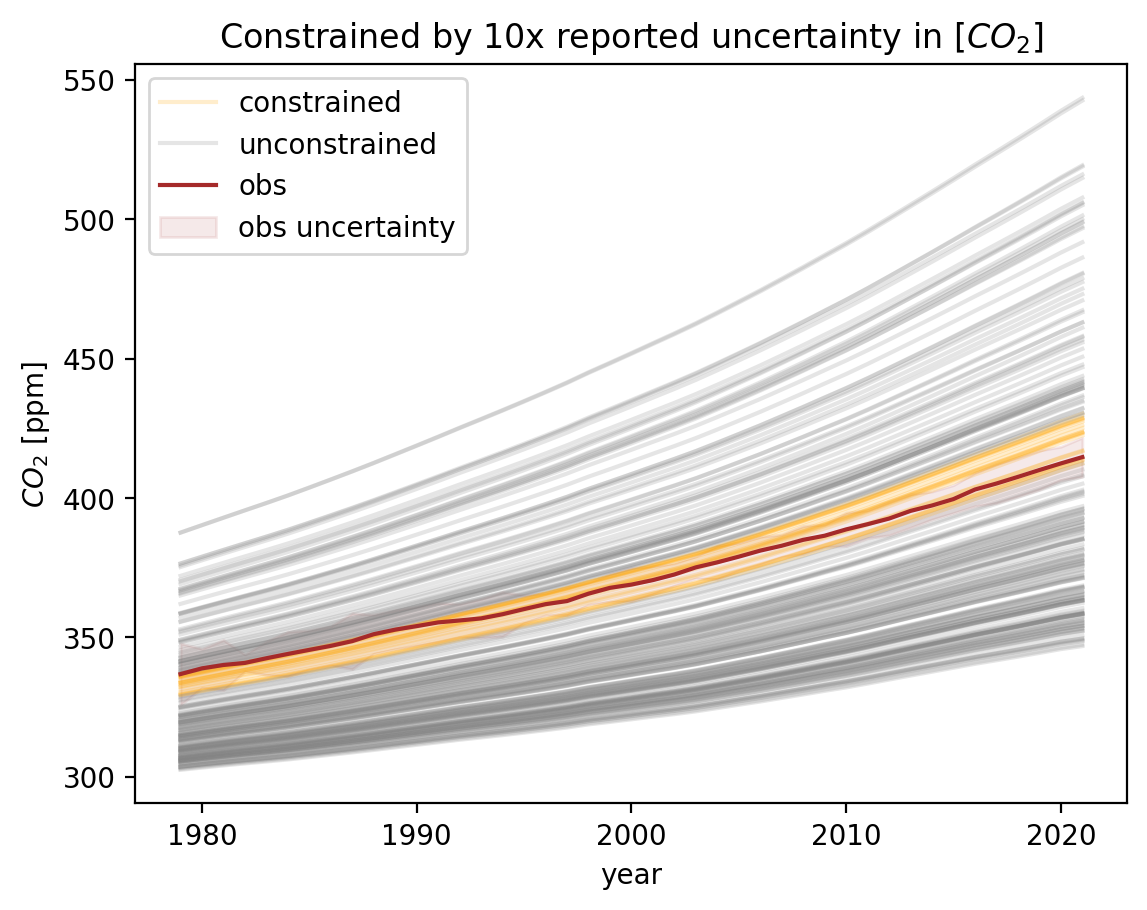

In [447]:
# plt.figure(dpi = 200)
fig, ax = plt.subplots(dpi = 200)
# line_up, = ax.plot([1, 2, 3], label='Line 2')
# line_down, = ax.plot([3, 2, 1], label='Line 1')
# ax.legend(handles=[line_up, line_down])

blast = 100
co2_constraint = gl_unc.sum('time')*blast

c_atm = f_gcbSD.co2_concentration.loc[dict(scenario='hist_gcb')]
c_atm['time'] = c_atm['time']+1850
constrained_by_co2 = []

for i in range(len(f_gcbSD.config)):
    # ens = c_atm.sel(timebounds = slice(gl_unc.time[0].values - 1850, gl_unc.time[-2].values-1850)).isel(config = i)
    ens = c_atm.sel(time = slice(gl_unc.time[0].values, gl_unc.time[-1].values)).isel(config = i)
    ens_resid = np.abs(ens.values-gl.values)
    if np.sum(ens_resid) < co2_constraint:
        constrained_by_co2.append(i)
        p0 = ax.plot(gl_unc.time, ens, c = 'orange', alpha = 0.2, label = 'constrained')
    else:
        pass
        p1 = ax.plot(gl_unc.time, ens, c = 'grey', alpha = 0.2, label = 'unconstrained')
p2 = ax.plot(gl_unc.time, gl, c = 'brown', alpha = 1, label ='obs')
p3 = ax.fill_between(gl.time, gl+blast*gl_unc, gl-blast*gl_unc, color = 'brown', alpha = 0.1, label = 'obs uncertainty')

# # Add p0[0] and p1[0] to the handles and labels
handles = [p0[0],p1[0],p2[0],p3]

# Add the legend with updated handles and labels
ax.legend(handles=handles,)
plt.xlabel('year')
plt.ylabel(r'$CO_{2}$ [ppm]')
plt.title('Constrained by 10x reported uncertainty in [$CO_2$]')

print(f'{len(constrained_by_co2)} configs pass the CO2 concentration constraint (x = {blast}): \n {constrained_by_co2}')

# plt.show();plt.close()

In [376]:
# Add changes to NPP_o and biology in ocean (maybe carbonate chemistry)

In [156]:
# Constrain from CO2 Growth Rate:

80 configs pass the GR constraint (x = 3): 
 [1, 7, 8, 11, 14, 15, 16, 18, 19, 20, 21, 24, 27, 28, 31, 32, 38, 42, 43, 45, 46, 47, 50, 53, 55, 57, 58, 59, 60, 65, 68, 70, 71, 73, 74, 76, 77, 83, 84, 87, 90, 93, 95, 96, 97, 104, 109, 111, 115, 118, 127, 129, 130, 136, 138, 139, 142, 146, 147, 156, 163, 165, 166, 169, 172, 173, 178, 179, 180, 181, 182, 183, 184, 185, 190, 193, 194, 195, 197, 199]


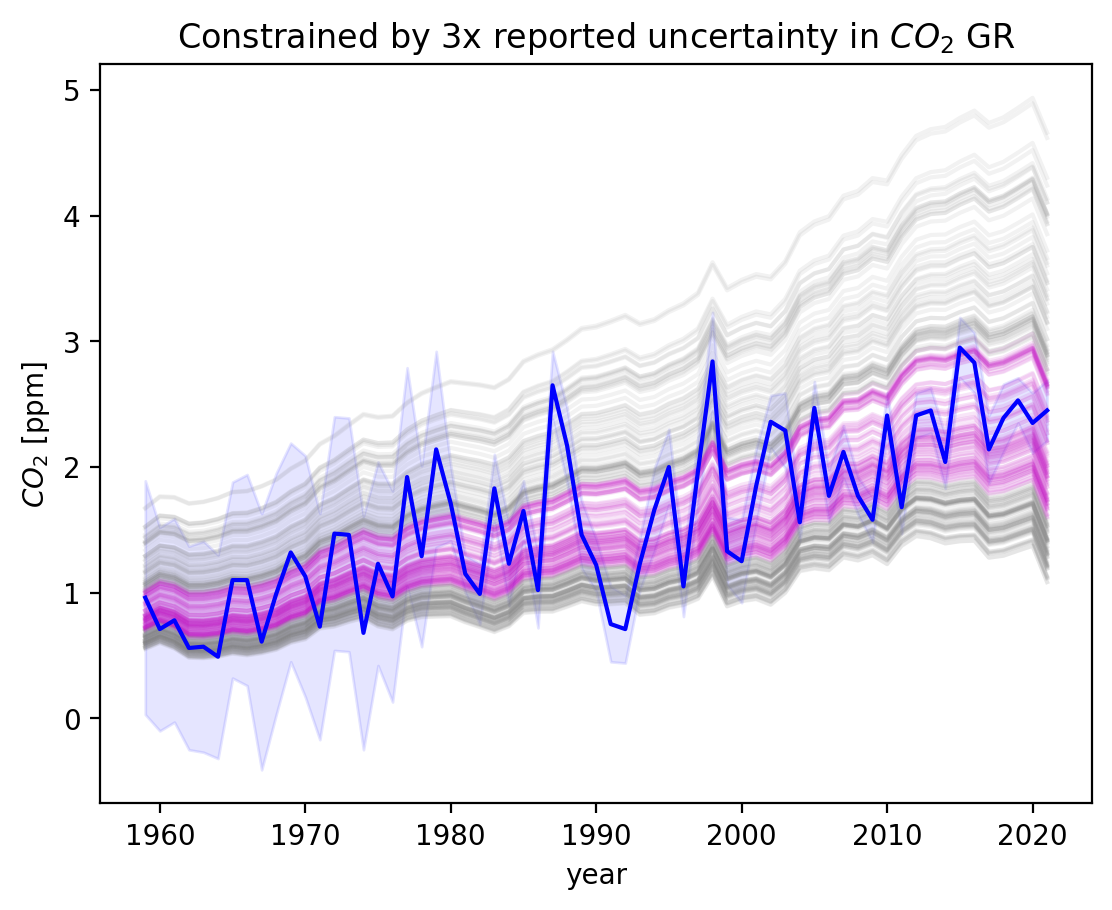

In [176]:
plt.figure(dpi = 200)

blast = 3
gr_constraint = gr_unc.sum('time')*blast

constrained_by_gr = []
for i in range(len(config_ens)):
    c_atm = f_gcbSD.co2_concentration.loc[dict(scenario='hist_gcb')]
    c_atm['time'] = c_atm['time']+1850
    gr_atm = c_atm.diff('time')
    # gr_atm
    ens = gr_atm.sel(time = gr_unc.time.values, config = i)
    ens_resid = np.abs(ens.values-gr.values)

    if np.sum(ens_resid) < gr_constraint:
        constrained_by_gr.append(i)
        plt.plot(gr_unc.time.values, ens, c = 'm', alpha = 0.1)
    else:
        pass
        plt.plot(gr_unc.time.values, ens, c = 'grey', alpha = 0.1)
plt.plot(gr.time, gr, c = 'b', alpha = 1)
plt.fill_between(gr.time, gr+blast*gr_unc, gr-blast*gr_unc, color = 'b', alpha = 0.1)

plt.xlabel('year')
plt.ylabel(r'$CO_{2}$ [ppm]')
plt.title(f'Constrained by {blast}x reported uncertainty in $CO_2$ GR')

print(f'{len(constrained_by_gr)} configs pass the GR constraint (x = {blast}): \n {constrained_by_gr}')

plt.show();plt.close()

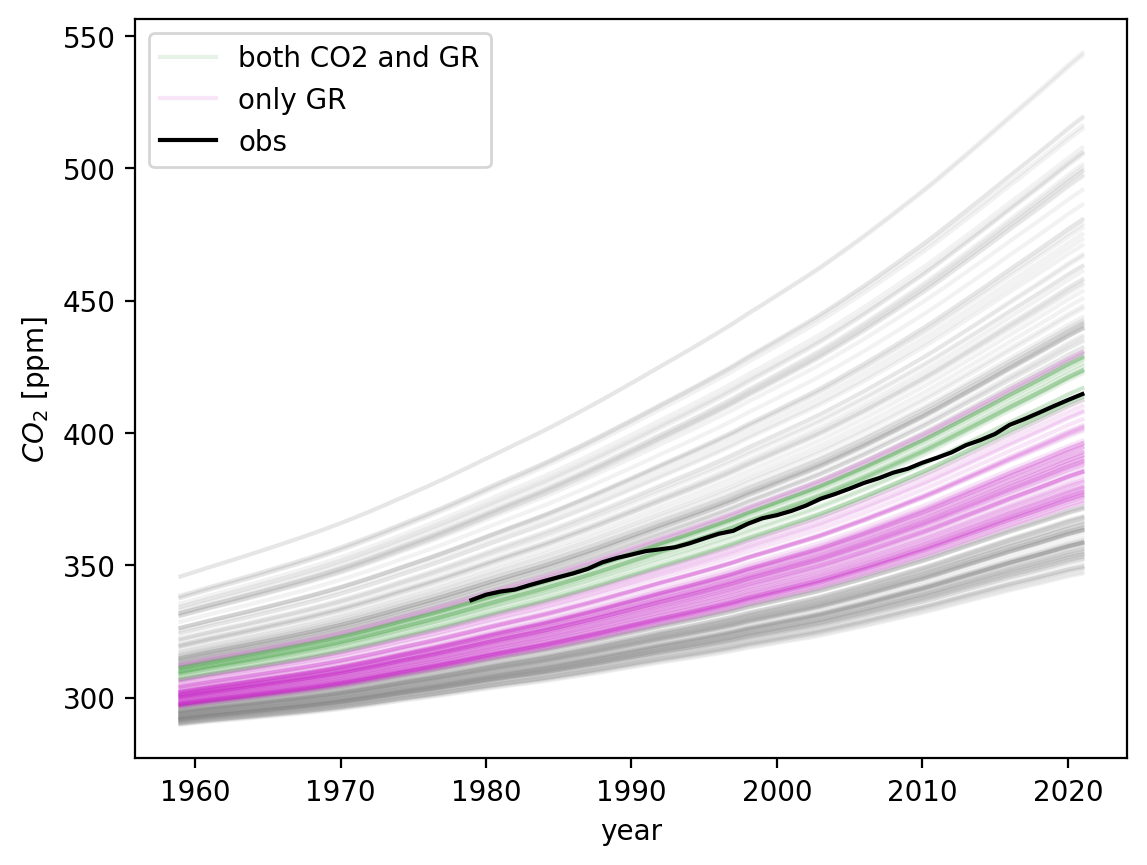

In [177]:
plt.figure(dpi = 200)

blast = 3
gr_constraint = gr_unc.sum('time')*blast

for config in config_ens:
    c_atm = f_gcbSD.co2_concentration.loc[dict(scenario='hist_gcb')]
    c_atm['time'] = c_atm['time']+1850
    c_atm = c_atm.sel(time = gr_unc.time.values, config=config)
    if config in constrained_by_co2:
        if config in constrained_by_gr:
            p1 = plt.plot(c_atm.time, c_atm, c = 'g', alpha = 0.1, label = 'both CO2 and GR')
        else:
            print('anything?')
            p2 = plt.plot(c_atm.time, c_atm, c = 'b', alpha = 0.1, label = 'only CO2')
    elif config in constrained_by_gr: #and not constrained_by_co2:
        p3 = plt.plot(c_atm.time, c_atm, c = 'm', alpha = 0.1, label = 'only GR')
    else:
        plt.plot(c_atm.time, c_atm, c = 'grey', alpha = 0.1, label = '_all members')
p4 = plt.plot(gl.time, gl, c = 'k', alpha = 1, label = 'obs')
plt.legend(handles = [p1[0], 
#                       p2[0], 
                      p3[0], p4[0]])
plt.xlabel('year')
plt.ylabel(r'$CO_{2}$ [ppm]')
# plt.title(f'Constrained by {blast}x reported uncertainty in $CO_2$ GR')
plt.show();plt.close()

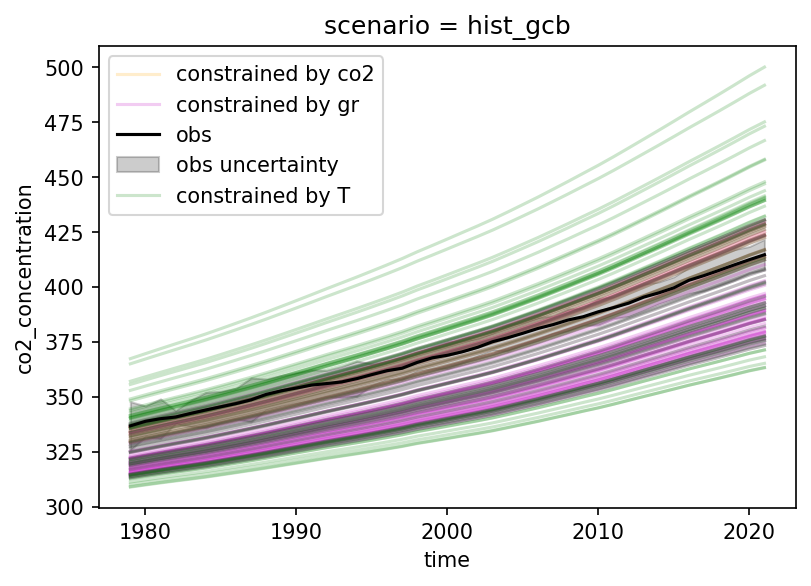

In [449]:
c_atm = f_gcbSD.co2_concentration.loc[dict(scenario='hist_gcb')]
c_atm['time'] = c_atm['time']+1850
ens_co2 = c_atm.sel(time = slice(gl_unc.time[0].values, gl_unc.time[-1].values),config = constrained_by_co2)
ens_gr = c_atm.sel(time = slice(gl_unc.time[0].values, gl_unc.time[-1].values),config = constrained_by_gr)
ens_T = c_atm.sel(time = slice(gl_unc.time[0].values, gl_unc.time[-1].values),config = constrained_by_T)

fig, ax = plt.subplots(dpi = 150, figsize = (6,4))

p0 = ens_co2.plot.line(ax = ax, x = 'time', c = 'orange', alpha = 0.2, label = 'constrained by co2')
p1 = ens_gr.plot.line(ax = ax, x = 'time', c = 'm', alpha = 0.2, label = 'constrained by gr')
p4 = ens_T.plot.line(ax = ax, x = 'time', c = 'g', alpha = 0.2, label = 'constrained by T')

p2 = ax.plot(gl_unc.time, gl, c = 'k', alpha = 1, label ='obs')
p3 = ax.fill_between(gl.time, gl+blast*gl_unc, gl-blast*gl_unc, color = 'k', alpha = 0.2, label = 'obs uncertainty')

# # Add p0[0] and p1[0] to the handles and labels
handles = [p0[0],p1[0],p2[0],p3,p4[0]]

# Add the legend with updated handles and labels
ax.legend(handles=handles,)

plt.show();plt.close()

In [389]:
# Constrain with Temperature

In [396]:
T = f_gcbSD.temperature.loc[dict(scenario = 'hist_gcb',)]

In [397]:
# Cowtan & Way in-filled dataset of global temperatures
CW = np.loadtxt('fair_local/defaults/data/obs/had4_krig_annual_v2_0_0.csv')
constrained = np.zeros(200, dtype=bool)

CW[:,0]
for i in range(200):
    # we use observed trend from 1880 to 2020
    constrained[i],_,_,_,_ = hist_temp(
        CW[30:,1], T[1880-1850:2021-1850,i], CW[30:,0])

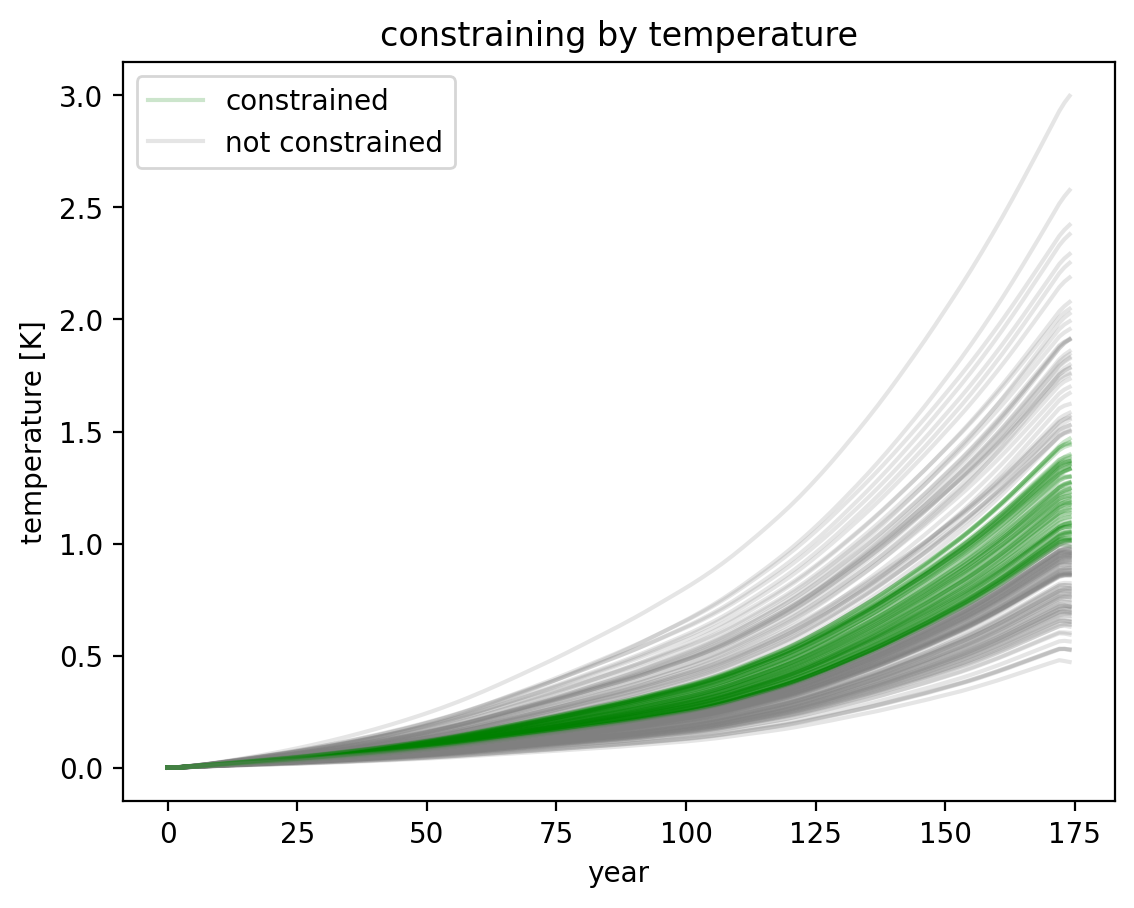

In [398]:
plt.figure(dpi = 200)
for i in range(200):
    if constrained[i]:
        p1 = plt.plot(T[:,i], c = 'g', alpha = 0.2, label = 'constrained')
    else:
        p2 = plt.plot(T[:,i], c = 'grey', alpha = 0.2, label = 'not constrained')
plt.legend(handles = [p1[0], p2[0]])
plt.title('constraining by temperature')
plt.ylabel('temperature [K]')
plt.xlabel('year')
plt.show()
plt.close()

In [419]:
constrained_by_T = []
for i in range(200):
    if constrained[i]:
        constrained_by_T.append(i)

In [421]:
constrained_T=[]
for i in range(200):
    if i in constrained_by_T:
        constrained_T.append(int(f_nonSD.config[i]))

In [412]:
constrained_co2=[]
for i in range(200):
    if i in constrained_by_co2:
        constrained_co2.append(int(f_nonSD.config[i]))

In [424]:
constrained_gr=[]
for i in range(200):
    if i in constrained_by_gr:
        constrained_gr.append(int(f_nonSD.config[i]))

In [408]:
constrained_gems = []
for i in range(200):
    if config_ens[i] in constrained_by_T:
        constrained_gems.append(int(f_nonSD.config[i]))
    elif config_ens[i] in constrained_by_gr:
        constrained_gems.append(int(f_nonSD.config[i]))
    elif config_ens[i] in constrained_by_co2:
        constrained_gems.append(int(f_nonSD.config[i]))
    else:
        pass
len(constrained_gems)

80

In [425]:
print(f'constrained_co2: {len(constrained_co2)},{constrained_co2}\n')
print(f'constrained_gr: {len(constrained_gr)},{constrained_gr}\n')
print(f'constrained_T: {len(constrained_T)},{constrained_T}\n')
print(f'constrained_gems: {len(constrained_gems)},{constrained_gems}\n')

constrained_co2: 19,[1715, 9680, 13729, 16767, 17813, 23590, 48679, 62962, 90101, 128300, 137878, 155878, 166241, 190811, 217600, 217680, 262404, 274614, 295377]

constrained_gr: 80,[1715, 7996, 8383, 9680, 12349, 13729, 14515, 15186, 16767, 17371, 17813, 23590, 28108, 28578, 41372, 43444, 48679, 58814, 61215, 62962, 66380, 67109, 74805, 82942, 84839, 90101, 92941, 94283, 95889, 103238, 104455, 105860, 107761, 111839, 113632, 114151, 116975, 127438, 128300, 130510, 137878, 142057, 145129, 146882, 150552, 155878, 163559, 166241, 172490, 177693, 190811, 192403, 194039, 207769, 210600, 212348, 213081, 217600, 217680, 229290, 240012, 243453, 252049, 255460, 262404, 266399, 270339, 274614, 278796, 281036, 282915, 283722, 284556, 286794, 294331, 295377, 295888, 296233, 297672, 299646]

constrained_T: 68,[3898, 7996, 8383, 9214, 9680, 12349, 14515, 16767, 17813, 23544, 23590, 28108, 30306, 37027, 41372, 48679, 51558, 58814, 62962, 66380, 67109, 84839, 90101, 94283, 95889, 104018, 105860, 1136

In [426]:
flat10_yesSD = xr.open_dataset('../output/flat10zec_all-output_fair2.1.3_gems_cal_1_2_0_df.nc')
flat10_nonSD = xr.open_dataset('../output/f_nonSD_200ens_all-output_fair2.1.3_cal_1_2_0_df.nc')

In [430]:
f_yesSD.config

<xarray.DataArray 'config' (config: 200)> Size: 2kB
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199])
Coordinates:
  * config   (config) int64 2kB 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199

done saving file


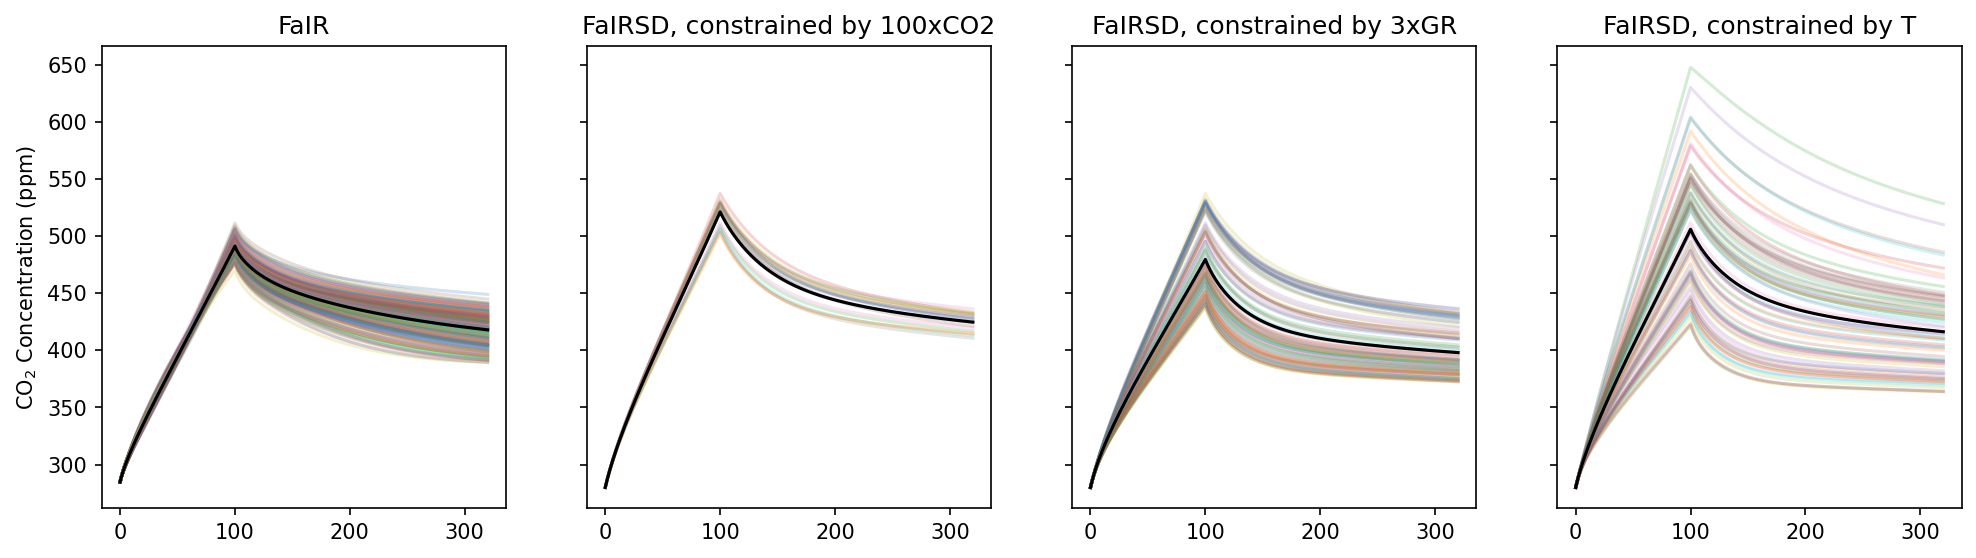

In [469]:
# plot all the configs CO2 concentration:

fig, ax = plt.subplots(1, 4, figsize = (16,4), dpi = 150, sharex=True, sharey=True)

a0 = ax[0].plot(f_nonSD['co2_concentration'].loc[dict(scenario = 'esm-flat10_zec',)], alpha = 0.2)
a0 = ax[0].plot(f_nonSD['co2_concentration'].loc[dict(scenario = 'esm-flat10_zec',)].mean('config'), alpha = 1, color = 'k')

a1 = ax[1].plot(f_yesSD['co2_concentration'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_co2), alpha = 0.2)
a1 = ax[1].plot(f_yesSD['co2_concentration'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_co2).mean('config'), alpha = 1, color = 'k')

a2 = ax[2].plot(f_yesSD['co2_concentration'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_gr), alpha = 0.2)
a2 = ax[2].plot(f_yesSD['co2_concentration'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_gr).mean('config'), alpha = 1, color = 'k')

a2 = ax[3].plot(f_yesSD['co2_concentration'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_T), alpha = 0.2)
a2 = ax[3].plot(f_yesSD['co2_concentration'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_T).mean('config'), alpha = 1, color = 'k')
ax[0].set_ylabel('CO$_2$ Concentration (ppm)')

ax[0].set_title('FaIR')
ax[1].set_title('FaIRSD, constrained by 100xCO2')
ax[2].set_title('FaIRSD, constrained by 3xGR')
ax[3].set_title('FaIRSD, constrained by T')

fpath = '../output/figs/'
fname = 'flat10zec_CO2_by_constraint'
# save the plot
fig.savefig(fpath+fname +'.png', bbox_inches='tight')
print('done saving file')

plt.show();plt.close()

done saving file


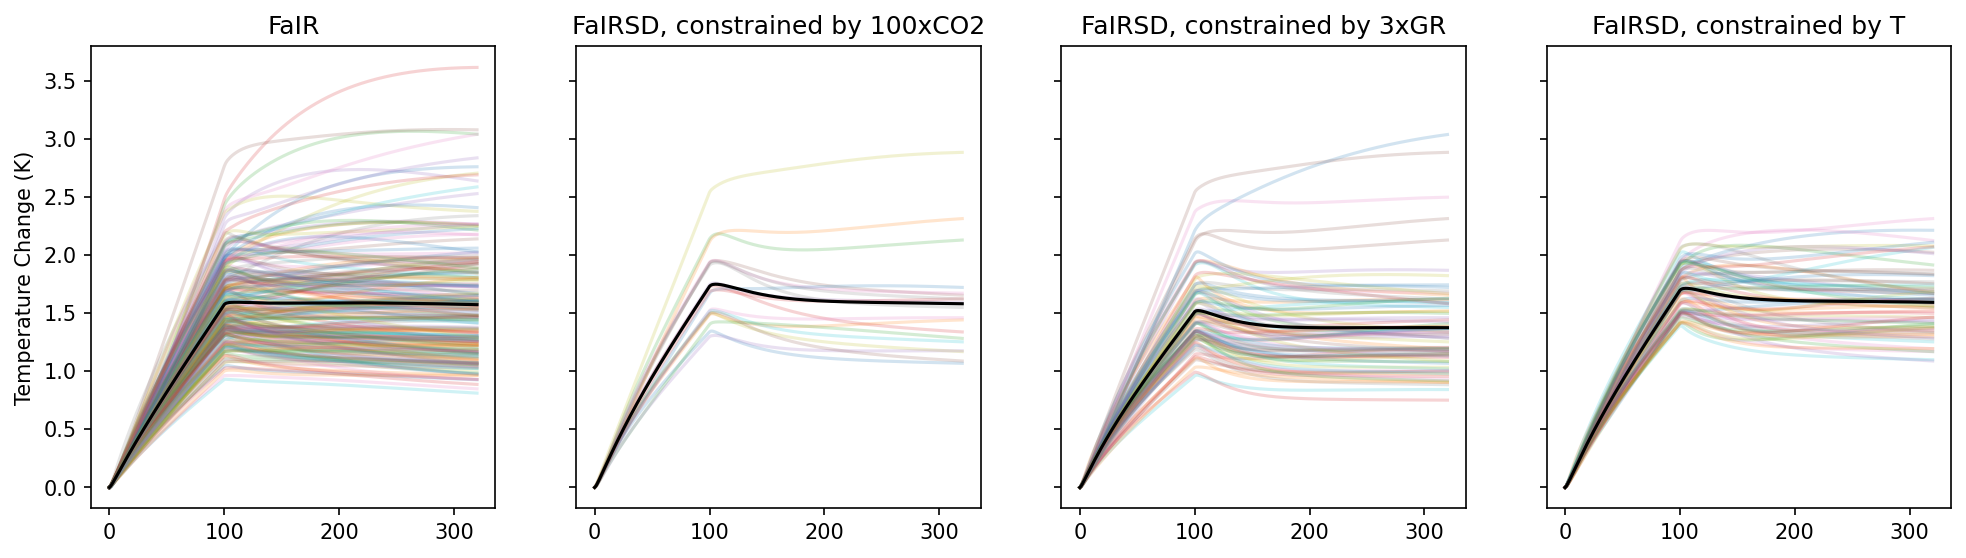

In [472]:
# plot all the configs CO2 concentration:

fig, ax = plt.subplots(1, 4, figsize = (16,4), dpi = 150, sharex=True, sharey=True)

a0 = ax[0].plot(f_nonSD['temperature'].loc[dict(scenario = 'esm-flat10_zec',)],alpha = 0.2,)
a0 = ax[0].plot(f_nonSD['temperature'].loc[dict(scenario = 'esm-flat10_zec',)].mean('config'),alpha = 1, color = 'k', label = 'ensemble mean')

a1 = ax[1].plot(f_yesSD['temperature'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_co2),alpha = 0.2,)
a1 = ax[1].plot(f_yesSD['temperature'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_co2).mean('config'),alpha = 1, color = 'k')

a2 = ax[2].plot(f_yesSD['temperature'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_gr), alpha = 0.2,)
a2 = ax[2].plot(f_yesSD['temperature'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_gr).mean('config'), alpha = 1, color = 'k')

a2 = ax[3].plot(f_yesSD['temperature'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_T), alpha = 0.2,)
a2 = ax[3].plot(f_yesSD['temperature'].loc[dict(scenario = 'esm-flat10_zec',)].sel( config = constrained_by_T).mean('config'), alpha = 1, color = 'k')

ax[0].set_title('FaIR')
ax[1].set_title('FaIRSD, constrained by 100xCO2')
ax[2].set_title('FaIRSD, constrained by 3xGR')
ax[3].set_title('FaIRSD, constrained by T')

ax[0].set_ylabel('Temperature Change (K)')
fpath = '../output/figs/'
fname = 'flat10zec_T_by_constraint'
# save the plot
fig.savefig(fpath+fname +'.png', bbox_inches='tight')
print('done saving file')

plt.show();plt.close()
plt.show();plt.close()

In [400]:
f_nonSD.config

<xarray.DataArray 'config' (config: 200)> Size: 2kB
array([  1230,   1715,   2658,   3898,   5915,   6306,   6661,   7996,   8383,
         9214,   9458,   9680,  11811,  12179,  12349,  13729,  14515,  14824,
        15186,  16767,  17371,  17813,  19515,  23544,  23590,  25361,  27136,
        28108,  28578,  30306,  37027,  41372,  43444,  44501,  44778,  45979,
        46609,  46634,  48679,  51558,  53424,  58185,  58814,  61215,  61316,
        62962,  66380,  67109,  73454,  74441,  74805,  77060,  81590,  82942,
        83449,  84839,  89645,  90101,  92941,  94283,  95889,  96217,  98882,
       101087, 102196, 103238, 104018, 104047, 104455, 104698, 105860, 107761,
       107817, 111839, 113632, 113811, 114151, 116975, 118983, 121134, 123476,
       123643, 125351, 127438, 128300, 130075, 130293, 130510, 131918, 134912,
       137878, 139571, 141797, 142057, 142944, 145129, 146882, 150552, 152550,
       152764, 153292, 154026, 154954, 155715, 155878, 159310, 159504, 162127,
       163241, 163559, 165730, 166241, 166644, 169318, 170382, 172490, 173678,
       177257, 177693, 180872, 182764, 183088, 184356, 185472, 187405, 187454,
       190510, 190811, 192189, 192403, 194039, 194898, 198705, 202437, 202501,
       202505, 207769, 209990, 210600, 212348, 212504, 212887, 213081, 213589,
       215177, 216230, 217600, 217680, 220193, 220966, 223501, 225503, 226274,
       226944, 227002, 228511, 229290, 230508, 231348, 234533, 236168, 238436,
       238665, 240012, 241899, 243453, 252049, 253588, 253983, 255460, 256757,
       260945, 262404, 266399, 266582, 267598, 268590, 270240, 270339, 274614,
       278796, 281036, 282915, 283722, 284556, 286794, 287872, 289433, 291399,
       293213, 294331, 295184, 295308, 295377, 295888, 296233, 296477, 297672,
       298383, 299646])
Coordinates:
  * config   (config) int64 2kB 1230 1715 2658 3898 ... 297672 298383 299646

In [ ]:
# Constraint from historical 

fig, ax = plt.subplots(1, 2, figsize = (8,4), dpi = 150, sharex=True, sharey=True)

for iconfig in f_nonSD.config:
    a0 = ax[0].plot(f_nonSD['co2_concentration'].loc[dict(scenario = 'esm-flat10_zec', config = iconfig)])
    
for iconfig in f_yesSD.config:
    a1 = ax[1].plot(f_yesSD['co2_concentration'].loc[dict(scenario = 'esm-flat10_zec', config = iconfig)])

plt.show();plt.close()